In [16]:
# 📦 Basic libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🔄 Progress bar and system tools
from tqdm import tqdm  # For tracking progress in loops
import sys             # For system-level operations (e.g., flushing output)

# ⚖️ Resampling techniques from imbalanced-learn
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, BorderlineSMOTE  # Over-sampling methods
from imblearn.under_sampling import RandomUnderSampler, NearMiss, ClusterCentroids, TomekLinks  # Under-sampling methods

# 🧪 Model preparation
from sklearn.model_selection import train_test_split       # For splitting dataset
from sklearn.preprocessing import StandardScaler           # For feature scaling
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # For evaluation

# 🤖 Classification models
from sklearn.linear_model import LogisticRegression        # Logistic Regression
from sklearn.tree import DecisionTreeClassifier            # Decision Tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier  # Tree ensembles
from sklearn.neighbors import KNeighborsClassifier         # K-Nearest Neighbors
from sklearn.naive_bayes import GaussianNB                 # Naive Bayes

# ⚡ Advanced boosting models
from xgboost import XGBClassifier                          # XGBoost
from lightgbm import LGBMClassifier                        # LightGBM
from catboost import CatBoostClassifier                    # CatBoost

In [2]:
# 📄 Load preprocessed and encoded datasets
train_encoded = pd.read_csv('train_encoded.csv')
test_encoded = pd.read_csv('test_encoded.csv')   

In [3]:
# drop 'ReimbursementDeductibleRatio' column from both train and test datasets
train_encoded.drop(columns='ReimbursementDeductibleRatio', inplace=True)
test_encoded.drop(columns='ReimbursementDeductibleRatio', inplace=True)

In [4]:
# feature and target definition
X = train_encoded.drop('PotentialFraud', axis=1)
y = train_encoded['PotentialFraud']

# split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scaled data to df to have feature names retained
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [5]:
# Resampling techniques
resamplers = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RandomOverSampler': RandomOverSampler(random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42),
    'RandomUnderSampler': RandomUnderSampler(random_state=42),
    'TomekLinks': TomekLinks(),
}

# Models with proper settings
models = {
    'LogisticRegression': LogisticRegression(solver='saga', max_iter=2000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB(),
    "XGBoost": XGBClassifier(eval_metric='logloss', verbosity=0),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),  
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)  
}

In [6]:
# Prepare balanced datasets with detailed progress and logging
balanced_data = {}
print("⚙️ Preparing balanced datasets...\n")

# Initialize progress bar
for name, sampler in tqdm(resamplers.items(), desc="Balancing Techniques", unit="technique", total=len(resamplers)):
    sys.stdout.write(f"\r🔄 Applying: {name}...") 
    sys.stdout.flush()  
    X_res, y_res = sampler.fit_resample(X_train_scaled_df, y_train)
    balanced_data[name] = (X_res, y_res)

print("\n✅ Balanced datasets ready.")

⚙️ Preparing balanced datasets...



Balancing Techniques:   0%|          | 0/6 [00:00<?, ?technique/s]

🔄 Applying: SMOTE...

Balancing Techniques:  17%|█▋        | 1/6 [01:23<06:57, 83.45s/technique]

🔄 Applying: ADASYN...

Balancing Techniques:  33%|███▎      | 2/6 [06:42<14:48, 222.19s/technique]

🔄 Applying: RandomOverSampler...

Balancing Techniques:  50%|█████     | 3/6 [06:43<06:02, 120.95s/technique]

🔄 Applying: BorderlineSMOTE...

Balancing Techniques:  67%|██████▋   | 4/6 [13:01<07:25, 222.56s/technique]

🔄 Applying: RandomUnderSampler...

Balancing Techniques:  83%|████████▎ | 5/6 [13:01<02:22, 142.43s/technique]

🔄 Applying: TomekLinks...

Balancing Techniques: 100%|██████████| 6/6 [24:14<00:00, 242.34s/technique]


✅ Balanced datasets ready.


In [7]:
results = []

# Evaluation
print("🔍 Starting model evaluation on all balanced datasets...\n")

for technique_name, (X_bal, y_bal) in balanced_data.items():
    print(f"\n📊 Evaluating Models for: {technique_name}\n{'-'*50}")
    for model_name, model in models.items():
        print(f"\n➡️ Training model: {model_name}")
        model.fit(X_bal, y_bal)
        y_pred = model.predict(X_test_scaled_df) 
        
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Metrics for class 0 and class 1
        precision_0 = report['0']['precision']
        recall_0 = report['0']['recall']
        f1_0 = report['0']['f1-score']

        precision_1 = report['1']['precision']
        recall_1 = report['1']['recall']
        f1_1 = report['1']['f1-score']

        results.append({
            'Technique': technique_name,
            'Model': model_name,
            'Accuracy': acc,
            'Precision_0': precision_0,
            'Recall_0': recall_0,
            'F1_0': f1_0,
            'Precision_1': precision_1,
            'Recall_1': recall_1,
            'F1_1': f1_1
        })

        # Print as usual
        print(f"✅ Accuracy: {acc:.4f}")
        print(f"\n📝 Classification Report for {model_name}:\n")
        print(classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])
        print(f"\n🔢 Confusion Matrix for {model_name} ({technique_name}):")
        print(cm_df)

print("\n✅ All model evaluations complete.")

🔍 Starting model evaluation on all balanced datasets...


📊 Evaluating Models for: SMOTE
--------------------------------------------------

➡️ Training model: LogisticRegression
✅ Accuracy: 0.7949

📝 Classification Report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.83      0.84      0.83    103507
           1       0.73      0.73      0.73     63687

    accuracy                           0.79    167194
   macro avg       0.78      0.78      0.78    167194
weighted avg       0.79      0.79      0.79    167194


🔢 Confusion Matrix for LogisticRegression (SMOTE):
               Predicted Negative  Predicted Positive
True Negative               86568               16939
True Positive               17348               46339

➡️ Training model: DecisionTree
✅ Accuracy: 0.9862

📝 Classification Report for DecisionTree:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99    103507
      

In [18]:
# Convert results to df
results_df = pd.DataFrame(results)

In [27]:
# Display results with enhanced styling
styled_table = results_df.style.background_gradient(
    cmap='coolwarm', 
    subset=['Accuracy', 'Precision_1', 'Recall_1', 'F1_1']
).format({
    'Accuracy': '{:.3f}',
    'Precision_1': '{:.3f}',
    'Recall_1': '{:.3f}',
    'F1_1': '{:.3f}'
}).set_table_styles([
    {
        'selector': 'th',
        'props': [('font-family', 'Consolas'), ('font-size', '10pt')]
    },
    {
        'selector': 'td',
        'props': [('font-family', 'Consolas'), ('font-size', '10pt')]
    },
    {
        'selector': 'caption',
        'props': [('font-family', 'Consolas'), ('font-size', '10pt'), ('font-weight', 'bold')]
    }
]).set_caption("📋 Model Evaluation Metrics")

styled_table

,Technique,Model,Accuracy,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
0,SMOTE,LogisticRegression,0.795,0.833057,0.836349,0.834700,0.732,0.728,0.730
1,SMOTE,DecisionTree,0.986,0.993389,0.984214,0.988780,0.975,0.989,0.982
2,SMOTE,RandomForest,0.928,0.909696,0.981122,0.944060,0.965,0.842,0.899
3,SMOTE,GradientBoosting,0.879,0.860776,0.959529,0.907474,0.919,0.748,0.825
4,SMOTE,AdaBoost,0.837,0.797329,0.986803,0.882005,0.965,0.592,0.734
5,SMOTE,KNN,0.683,0.769077,0.697257,0.731408,0.573,0.660,0.613
6,SMOTE,NaiveBayes,0.808,0.814879,0.891756,0.851586,0.792,0.671,0.726
7,SMOTE,XGBoost,0.962,0.951924,0.988416,0.969827,0.980,0.919,0.948
8,SMOTE,LightGBM,0.932,0.916578,0.978813,0.946674,0.961,0.855,0.905
9,SMOTE,CatBoost,0.991,0.986521,0.999102,0.992771,0.999,0.978,0.988


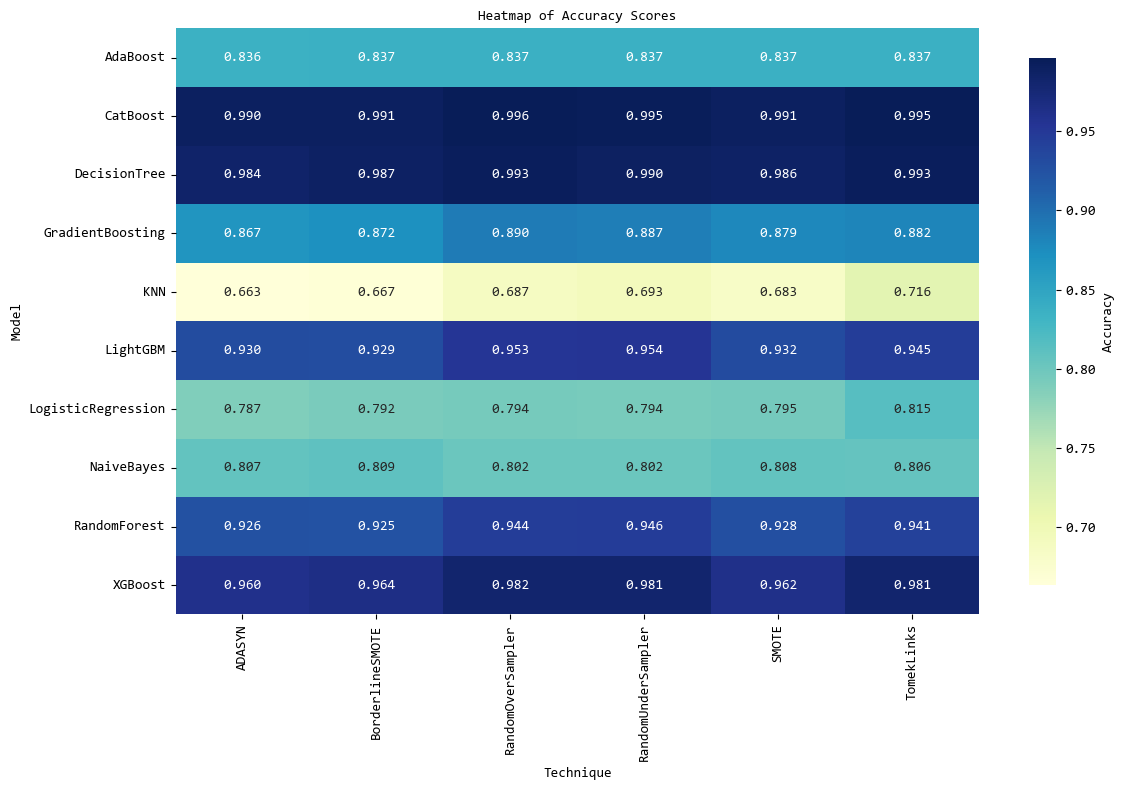

In [24]:
# Set global font properties
plt.rcParams.update({
    'font.family': 'Consolas',
    'font.size': 10
})

# Create pivot table for heatmap
pivot_acc = results_df.pivot(index='Model', columns='Technique', values='Accuracy')

# Plot heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(pivot_acc, annot=True, fmt=".3f", cmap='YlGnBu',
                 cbar_kws={'label': 'Accuracy', 'shrink': 0.9})

# Set font properties explicitly
ax.set_title('Heatmap of Accuracy Scores', fontname='Consolas', fontsize=10)
ax.set_xlabel('Technique', fontname='Consolas', fontsize=10)
ax.set_ylabel('Model', fontname='Consolas', fontsize=10)

# Update tick labels font
ax.set_xticklabels(ax.get_xticklabels(), fontname='Consolas', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontname='Consolas', fontsize=10, rotation=0)

# Update colorbar font
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=10)
colorbar.ax.yaxis.label.set_fontname('Consolas')
colorbar.ax.yaxis.label.set_size(10)

plt.tight_layout()
plt.show()

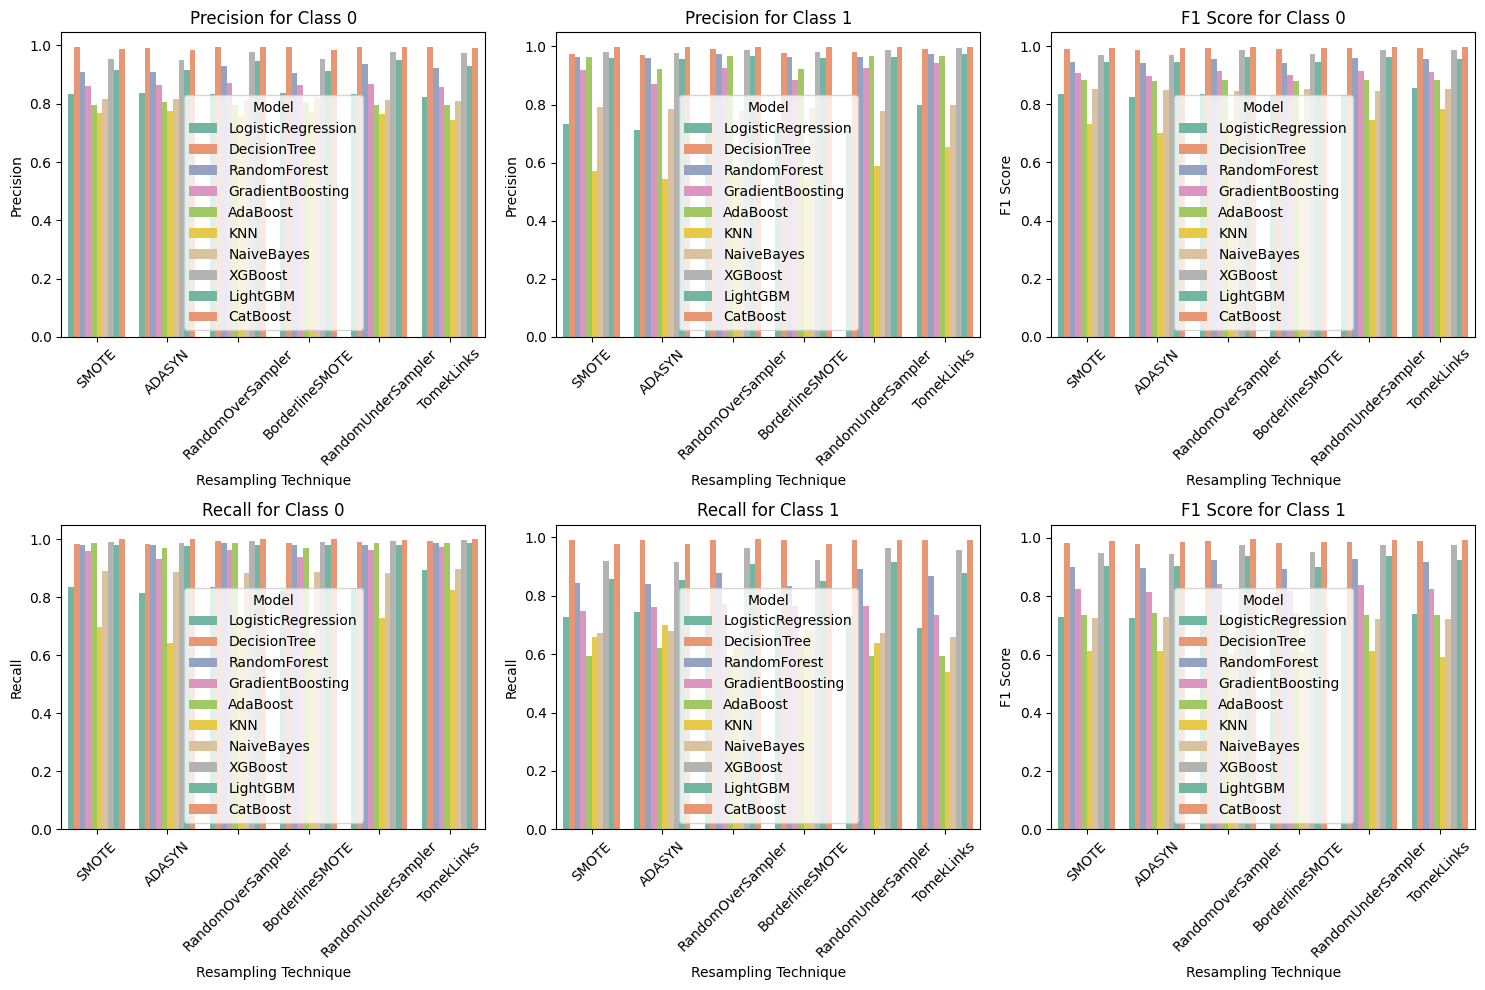

In [12]:
# Bar plot for Precision, Recall, and F1 for Class 0 and Class 1
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Precision
sns.barplot(x='Technique', y='Precision_0', hue='Model', data=results_df, ax=ax[0, 0], palette='Set2')
ax[0, 0].set_title('Precision for Class 0')
ax[0, 0].set_xlabel('Resampling Technique')
ax[0, 0].set_ylabel('Precision')
ax[0, 0].tick_params(axis='x', rotation=45)

sns.barplot(x='Technique', y='Precision_1', hue='Model', data=results_df, ax=ax[0, 1], palette='Set2')
ax[0, 1].set_title('Precision for Class 1')
ax[0, 1].set_xlabel('Resampling Technique')
ax[0, 1].set_ylabel('Precision')
ax[0, 1].tick_params(axis='x', rotation=45)

# Recall
sns.barplot(x='Technique', y='Recall_0', hue='Model', data=results_df, ax=ax[1, 0], palette='Set2')
ax[1, 0].set_title('Recall for Class 0')
ax[1, 0].set_xlabel('Resampling Technique')
ax[1, 0].set_ylabel('Recall')
ax[1, 0].tick_params(axis='x', rotation=45)

sns.barplot(x='Technique', y='Recall_1', hue='Model', data=results_df, ax=ax[1, 1], palette='Set2')
ax[1, 1].set_title('Recall for Class 1')
ax[1, 1].set_xlabel('Resampling Technique')
ax[1, 1].set_ylabel('Recall')
ax[1, 1].tick_params(axis='x', rotation=45)

# F1 Score
sns.barplot(x='Technique', y='F1_0', hue='Model', data=results_df, ax=ax[0, 2], palette='Set2')
ax[0, 2].set_title('F1 Score for Class 0')
ax[0, 2].set_xlabel('Resampling Technique')
ax[0, 2].set_ylabel('F1 Score')
ax[0, 2].tick_params(axis='x', rotation=45)

sns.barplot(x='Technique', y='F1_1', hue='Model', data=results_df, ax=ax[1, 2], palette='Set2')
ax[1, 2].set_title('F1 Score for Class 1')
ax[1, 2].set_xlabel('Resampling Technique')
ax[1, 2].set_ylabel('F1 Score')
ax[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall Curve for all models
plt.figure(figsize=(12, 8))

for model_name, model in models.items():
    y_prob = model.predict_proba(X_test_scaled_df)[:, 1]  # Get predicted probabilities for the positive class
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    
    plt.plot(recall, precision, label=f'{model_name}')

plt.title('Precision-Recall Curve for All Models')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix heatmap for a specific model and technique
model_name = 'RandomForestClassifier'  # Example model
technique_name = 'SMOTE'  # Example resampling technique

# Filter the results for the specific model and technique
filtered_results = results_df[(results_df['Model'] == model_name) & (results_df['Technique'] == technique_name)]
y_pred = models[model_name].predict(X_test_scaled_df)  # Assuming model is trained and X_test_scaled_df is available

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Plotting the heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 16})
plt.title(f'Confusion Matrix for {model_name} ({technique_name})')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()